In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import PIL
import os
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization

# Local imports
import sys
sys.path.append('../../../')
import stlstuff as sls
import imagestuff as ims
import statstuff as sts

In [2]:
%matplotlib notebook

In [3]:
# Graphics parameters
fontsize = 10
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

In [4]:
# Set defaults for the analysis
numforhist = 55

# This is for "segments"
#accumlist = [4,5,6,7,8,9,10,11,12] # This will get filled in as the entire set of segments unless overridden here

# This is for "segments2"
accumlist = [] # This will get filled in below

eta_visual = .95
rminforhist = 1e-7
rmaxforhist = .6

In [5]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentroot='Segments2'

/Users/nesh/Documents/repositories/ice4/crystals/2018-07-05 /Case1.3
2018-07-05 /Case1.3


In [6]:
# Derivative names
Compressedfilename = Segmentroot+'retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentroot+'roughness.jpg'; print(Roughnessfile)
Roughnessdatafile=Segmentroot+'roughness.txt'; print(Roughnessdatafile)

Segments2retrieved.npz
Segments2roughness.jpg
Segments2roughness.txt


In [7]:
# Get the retrieved surface
npzfile = np.load(Compressedfilename)
imageroot = np.array_str(npzfile['imageroot'])
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("dx and dy", dx, dy)

dx and dy 0.2834821 0.2834821


In [8]:
nx1list = npzfile['nx1list']
nx2list = npzfile['nx2list']
ny1list = npzfile['ny1list']
ny2list = npzfile['ny2list']
pA = npzfile['pA']
pB = npzfile['pB']
pC = npzfile['pC']
pD = npzfile['pD']
sA = npzfile['sA']
sB = npzfile['sB']
sC = npzfile['sC']
sD = npzfile['sD']
nxi = npzfile['nxi']
nyi = npzfile['nyi']
dnx = npzfile['dnx']
dny = npzfile['dny']
solution = npzfile['solution']
nsegments = len(nx1list)
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]
    
print('Completed',case) #Prints loading but I wanted to know when it was done.

Completed 2018-07-05 /Case1.3


In [9]:
Iwantroughness = True
Iwanttosave = True
Iwantlog = True
IwantURT = True

<IPython.core.display.Javascript object>


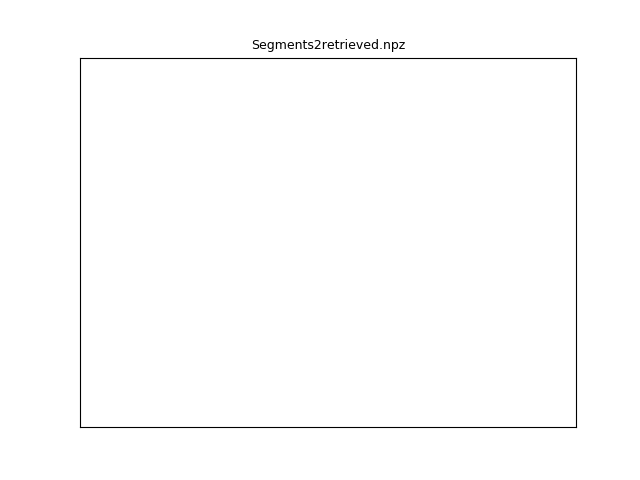

In [10]:
# Graph the segments
im = PIL.Image.open(Filename)
ny_im,nx_im = np.shape(im)
draw = PIL.ImageDraw.Draw(im)
fig, ax = plt.subplots()
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)
ax.set_title(Compressedfilename,fontsize=fontsize*0.9)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.show(im,cmap = 'Greys_r', vmin = 0,vmax = 255)
im.show() # This shouldn't be necessary but there seems to be a bug with plt.show

In [11]:
# Setting up null arrays
hbins_accum = []
meanrsub_accum = []
zsigma_accum = []
Z2_accum = []
Zsquared_accum = []
rsub_accum = []
meanrsublist = []
Zsigmalist = []
Z2list = []

# And a graphics parameter
stride = 1

In [12]:
# Now, to evaluate the roughness ... First step is to flatten each panel via rotation
# Here we explicitly flip the y-coordinate (to make it a right-handed system) so we don't have to invert on the fly

for isegment in range(0,nsegments):
#for isegment in range(15,16):

    # Extract this segment
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nxsegment = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; nysegment = ny2-ny1+1
    surf_xseg = np.linspace(0,(nxsegment-1)*dx,nxsegment); 
    surf_yseg = np.linspace(0,(nysegment-1)*dy,nysegment); 
    surf_xseggrid, surf_yseggrid = np.meshgrid(surf_xseg,surf_yseg) # 1st index is y, 2nd is x
    surf_zseggrid = copy.copy(np.flipud(solution[ny1:ny2+1,nx1:nx2+1])) # This flips the y-coordinate

    # Fit a plane to the data and adjust data to start at the origin
    m = ims.polyfit2d(\
                  surf_xseggrid.reshape(nysegment*nxsegment), \
                  surf_yseggrid.reshape(nysegment*nxsegment), \
                  surf_zseggrid.reshape(nysegment*nxsegment), \
                  linear=True,order=1)

    # Get the angles of the plane
    dzdy = m[1]; thetay = np.arctan(dzdy)*180/np.pi; #print 'y:', thetay

    # Get rotation matrix & flatten in one direction
    Roty = ims.myrotation_matrix([1,0,0], -thetay)
    surf_xseggridp, surf_yseggridp, surf_zseggridp = \
        ims.flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid, Roty)

    # Fit a plane to the data and adjust data to start at the origin
    mp = ims.polyfit2d(\
                  surf_xseggridp.reshape(nysegment*nxsegment), \
                  surf_yseggridp.reshape(nysegment*nxsegment), \
                  surf_zseggridp.reshape(nysegment*nxsegment), \
                  linear=True,order=1)

    # Get the angle of the plane in another direction
    dzdx = mp[2]; thetaxp = np.arctan(dzdx)*180/np.pi; #print 'x:', thetaxp

    # Get rotation matrix & flatten in another direction
    Rotxp = ims.myrotation_matrix([0,1,0], thetaxp)
    surf_xseggridpp, surf_yseggridpp, surf_zseggridpp = \
        ims.flatten(surf_xseggridp, surf_yseggridp, surf_zseggridp, Rotxp)


    # Trying out the polyval2d
    surf_zseggrid_theory_long = ims.polyval2d(\
                  surf_xseggrid.reshape(nysegment*nxsegment), \
                  surf_yseggrid.reshape(nysegment*nxsegment), \
                  m)
    surf_zseggrid_theory = surf_zseggrid_theory_long.reshape(nysegment,nxsegment)
    #surf_zseggrid_theory -= z0
    surf_xseggridp_theory, surf_yseggridp_theory, surf_zseggridp_theory = \
        ims.flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid_theory, Roty)
    surf_xseggridpp_theory, surf_yseggridpp_theory, surf_zseggridpp_theory = \
        ims.flatten(surf_xseggridp_theory, surf_yseggridp_theory, surf_zseggridp_theory, Rotxp)

    # Now rotate
    deltay = surf_yseggridpp_theory[0,-1]-surf_yseggridpp_theory[0,0]
    deltax = surf_xseggridpp_theory[0,-1]-surf_xseggridpp_theory[0,0]
    thetazpp = -np.arctan(deltay/deltax)*180/np.pi;
    Rotzpp = ims.myrotation_matrix([0,0,1], thetazpp)
    surf_xseggridppp, surf_yseggridppp, surf_zseggridppp = \
        ims.flatten(surf_xseggridpp, surf_yseggridpp, surf_zseggridpp, Rotzpp)
    surf_xseggridppp_theory, surf_yseggridppp_theory, surf_zseggridppp_theory = \
        ims.flatten(surf_xseggridpp_theory, surf_yseggridpp_theory, surf_zseggridpp_theory, Rotzpp)

    # Now we have to extract an orthogonal subset
    dxsub = dysub = dx
    xsubstart = np.max(surf_xseggridppp_theory[[0,-1],0])+dxsub*2
    xsubstop = np.min(surf_xseggridppp_theory[[0,-1],-1])-dxsub*2
    ysubstart = np.max(surf_yseggridppp_theory[0,[0,-1]])+dysub*2
    ysubstop = np.min(surf_yseggridppp_theory[-1,[0,-1]])-dysub*2
    xsub = np.arange(xsubstart,xsubstop,dxsub)
    ysub = np.arange(ysubstart,ysubstop,dysub)
    sub_xseggrid, sub_yseggrid = np.meshgrid(xsub,ysub) # 1st index is y, 2nd is x
    nsuby, nsubx = np.shape(sub_xseggrid)
    surf_xseggridppp_theory_long = np.reshape(surf_xseggridppp_theory,nysegment*nxsegment)
    surf_yseggridppp_theory_long = np.reshape(surf_yseggridppp_theory,nysegment*nxsegment)
    points = np.vstack((surf_xseggridppp_theory_long,surf_yseggridppp_theory_long)).T # rows are x,y pairs
    values = np.reshape(surf_zseggridppp,nysegment*nxsegment)
    sub_zseggrid_long = griddata(points, values, (sub_xseggrid, sub_yseggrid), method='cubic')
    sub_zseggrid = np.reshape(sub_zseggrid_long,(nsuby, nsubx))

    # Now we get the roughness
    dzsub_dx = np.diff(sub_zseggrid,axis=1)/np.diff(sub_xseggrid,axis=1)
    dzsub_dy = np.diff(sub_zseggrid,axis=0)/np.diff(sub_yseggrid,axis=0)
    Zsquared = dzsub_dx[1:,:]**2+dzsub_dy[:,1:]**2
    rsub = 1.0 - 1/np.sqrt(1+Zsquared)
    mu = 1-rsub
    phi = np.arccos(mu)
    Zplus = Zsquared**.5
    Z = np.hstack((Zplus,-Zplus)) # Need +/- to generate a two-sided distribution
    thismeanrsub = np.round(np.mean(rsub)*1000)/1000; meanrsublist.append(thismeanrsub)
    thissigma = np.round(np.std(Z)*100)/100; Zsigmalist.append(thissigma)
    thismeanZ2 = np.mean(Zsquared); Z2list.append(thismeanZ2)

    # Plotting surfaces
    title1 = 'panel_' +list(map(str,[isegment+1]))[0]#"TypeError: 'map' object is not subscriptable" stackoverflow said added the list() so the map is indexable

    # Numerical distribution functions
    rsub_long = np.reshape(rsub,np.size(rsub))

    # This needs to be changed to adjust for log spacing
    newrbins=np.geomspace(rminforhist,rmaxforhist,num=numforhist)
    hist = np.histogram(rsub_long,bins=newrbins)

    rbins = hist[1][0:-1]
    rbins1 = hist[1][1:]
    hbins = hist[0] 
    norm = -np.trapz(rbins,hbins)
    hbins = hbins/norm

    # Defining the analytical distribution function bins
    rwidth = rbins1-rbins
    rbinsW = (rbins+rwidth/2.0)        

    # Accumulate the binned data
    if isegment in accumlist:
        hbins_accum.append(hbins)
        meanrsub_accum.append(thismeanrsub)
        zsigma_accum.append(thissigma)
        Z2_accum.append(thismeanZ2)

        Zsquared_long = np.reshape(Zsquared,np.size(Zsquared))
        Zsquared_accum = np.append(Zsquared_accum,Zsquared_long)

        rsub_long = np.reshape(rsub,np.size(rsub))
        rsub_accum = np.append(rsub_accum,rsub_long)

        print('Accumulating ...', np.shape(Zsquared), np.shape(Zsquared_long), np.shape(Zsquared_accum))


print(newrbins)
for isegment in range(len(meanrsublist)):
    print('segment, #pts, <r>, sigma =', \
         isegment, np.size(rsub), meanrsublist[isegment], Zsigmalist[isegment])

../../../imagestuff.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(G, z)


Accumulating ... (36, 37) (1332,) (1332,)
Accumulating ... (36, 41) (1476,) (2808,)
Accumulating ... (36, 44) (1584,) (4392,)
Accumulating ... (36, 42) (1512,) (5904,)
Accumulating ... (36, 42) (1512,) (7416,)
Accumulating ... (36, 38) (1368,) (8784,)
Accumulating ... (36, 39) (1404,) (10188,)
Accumulating ... (36, 38) (1368,) (11556,)
Accumulating ... (36, 38) (1368,) (12924,)
Accumulating ... (36, 38) (1368,) (14292,)
Accumulating ... (36, 36) (1296,) (15588,)
Accumulating ... (36, 36) (1296,) (16884,)
Accumulating ... (36, 35) (1260,) (18144,)
Accumulating ... (36, 35) (1260,) (19404,)
Accumulating ... (36, 35) (1260,) (20664,)
[1.00000000e-07 1.33512313e-07 1.78255377e-07 2.37992877e-07
 3.17749794e-07 4.24235099e-07 5.66406093e-07 7.56221875e-07
 1.00964932e-06 1.34800615e-06 1.79975419e-06 2.40289345e-06
 3.20815862e-06 4.28328678e-06 5.71871525e-06 7.63518900e-06
 1.01939174e-05 1.36101349e-05 1.81712059e-05 2.42607973e-05
 3.23911516e-05 4.32461757e-05 5.77389694e-05 7.70886335

40.6712197348511


<IPython.core.display.Javascript object>


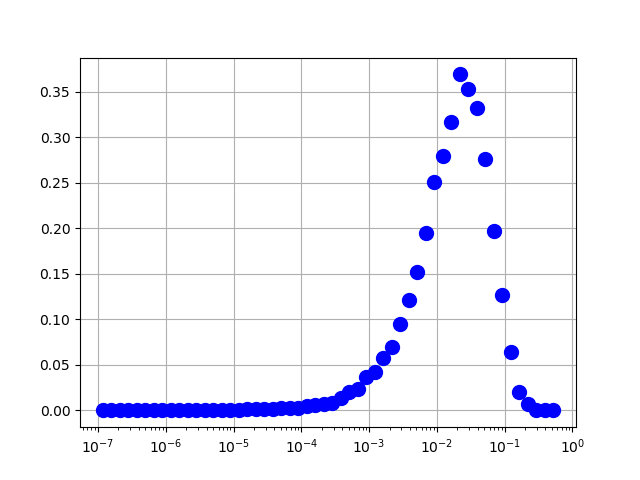

In [13]:
# This graphs observed results

# Calculate the observed histogram
hbins_total = np.sum((hbins_accum),axis=0)/len(accumlist)

# Normalize
norm = -np.trapz(np.log(rbinsW),hbins_total); print(norm)
hbins_total = hbins_total/norm

# Graph it
plt.figure()
plt.semilogx(rbinsW,hbins_total,'ob',markersize=10, label='obs')
plt.grid(True)

In [14]:
# Get the best Weibull fit
x0 = np.array([0.1])
solution, solutionerror = optimization.curve_fit(sts.pGaussianr, rbinsW, hbins_total, x0)
best_sigmaG = solution[0]; 
print('Gaussian: best_sigma = ', best_sigmaG)

# Get the best Weibull fit
x0 = np.array([0.1,1.0])
solution, solutionerror = optimization.curve_fit(sts.pWeibullr, rbinsW, hbins_total, x0)
best_sigmaW = solution[0]; 
print('Weibull: best_sigma = ', best_sigmaW)
best_eta = solution[1]
print('Weibull: best_eta = ', best_eta)

# Get the best match for a two-gaussian fit
x0 = np.array([0.2,0.1,.5])
solution, solutionerror = optimization.curve_fit(sts.bimodalfunc, rbinsW, hbins_total, x0)
best_sigma1 = solution[0]
best_N1 = 1-solution[2]
print('Bimodal: best_sigma1,N1 = ', best_sigma1,best_N1)
best_sigma2 = solution[1]
best_N2 = solution[2]
print('Bimodal: best_sigma2,N2 = ', best_sigma2,best_N2)

Gaussian: best_sigma =  0.2389602495899374
Weibull: best_sigma =  0.23742009100445247
Weibull: best_eta =  0.9324090327327051
Bimodal: best_sigma1,N1 =  0.3127601781704924 0.332616309763221
Bimodal: best_sigma2,N2 =  0.21061440486459687 0.667383690236779


In [15]:
# Get the best-fit distributions
hbins_gauss = sts.pWeibullr(rbinsW, best_sigmaG, 1)
R2_G = sts.R_squar(hbins_total,hbins_gauss)
print('R^2 (Gauss) = ', R2_G)
hbins_bestfit = sts.pWeibullr(rbinsW, best_sigmaW, best_eta)
R2_W = sts.R_squar(hbins_total,hbins_bestfit)
print('R^2 (Weibull) = ', R2_W)
hbins_bimodal = sts.bimodalfunc(rbinsW, best_sigma1, best_sigma2, best_N2)
R2_B = sts.R_squar(hbins_total,hbins_bimodal)
print('R^2 (Bimodal) = ', R2_B)

R^2 (Gauss) =  0.9924508302526933
R^2 (Weibull) =  0.9972026600127025
R^2 (Bimodal) =  0.9990498106378974


In [16]:
# Labels for graph
label_obs = 'obs'
label_Gauss = 'Gaussian: ' \
                +'$\sigma$='+str(np.round(best_sigmaG*100)/100) + '\n'\
                +'$R^2=$'+str(np.round(R2_G*1000)/1000) 
label_Weibull = 'Weibull: ' \
                +'$\sigma_W$='+str(np.round(best_sigmaW*100)/100) \
                +', ' +'$\eta_W$='+str(np.round(best_eta*100)/100) + '\n'\
                +'$R^2=$'+str(np.round(R2_W*1000)/1000) 

label_bimodal = 'Bimodal: ' + '\n'\
                +'$\sigma_1$='+str(np.round(best_sigma1*100)/100) \
                +', '+'$N_1$='+str(np.round(best_N1*100)/100) + '\n'\
                +'$\sigma_2$='+str(np.round(best_sigma2*100)/100) \
                +', '+'$N_2$='+str(np.round(best_N2*100)/100) + '\n'\
                +'$R^2=$'+str(np.round(R2_B*1000)/1000) 



<IPython.core.display.Javascript object>


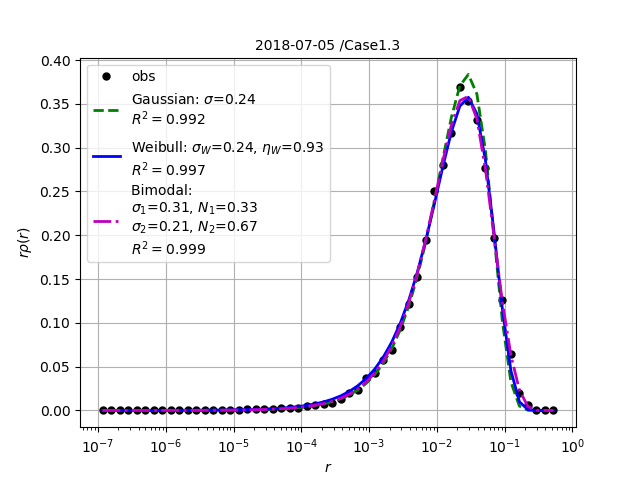

Text(0.5,1,'2018-07-05 /Case1.3')

In [17]:
# Graph
plt.figure()
plt.semilogx(rbinsW,hbins_total,'ok',markersize=5, label=label_obs)
plt.semilogx(rbinsW,hbins_gauss,'--g',linewidth=2, label=label_Gauss)
plt.semilogx(rbinsW,hbins_bestfit,'-b',linewidth=2, label=label_Weibull)
plt.semilogx(rbinsW,hbins_bimodal,'-.m',linewidth=2, label=label_bimodal)
plt.grid(True)
plt.xlabel(r'$r$',fontsize=fontsize)
plt.ylabel(r'$r\rho(r)$',fontsize=fontsize)
plt.legend(loc='upper left')
plt.title(case,fontsize=fontsize)

In [18]:
if Iwanttosave:
    plt.savefig(Roughnessfile)
    dummy= [rbinsW,hbins_total]
    np.savetxt(Roughnessdatafile,dummy)
    cfile = open('roughnessfit.txt','w')
    cfile.write('&Roughness_Best_Fit\n')
    cfile.write('2016-06-30-ice1 Case1.2.1'+'\n\n'+'Gaussian fit:'+'\n')
    cfile.write('   '+'sigma =' +str(best_sigmaG)+'\n')
    cfile.write('   '+'R^2 ='+str(R2_G)+'\n\n'+'Weibull fit:'+'\n')
    cfile.write('   '+'sigma =' +str(best_sigmaW)+'\n')
    cfile.write('   '+'eta =' +str(best_eta)+'\n')
    cfile.write('   '+'R^2 ='+str(R2_W)+'\n\n'+'Bimodal fit:'+'\n')
    cfile.write('   '+'sigma1 =' +str(best_sigma1)+'\n')
    cfile.write('   '+'N1 =' +str(best_N1)+'\n')
    cfile.write('   '+'sigma2 =' +str(best_sigma2)+'\n')
    cfile.write('   '+'N2 =' +str(best_N2)+'\n')
    cfile.write('   '+'R^2 ='+str(R2_B)+'\n')
    cfile.close()

In [19]:
pwd

'/Users/nesh/Documents/repositories/ice4/crystals/2018-07-05 /Case1.3'